TODOs to make optimization or sampling tractable:
- Implement dirichlet transform thing
- Test on case where true density scale heights wrong
- ...

In [1]:
import pickle
from functools import partial

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
import corner
from tqdm.auto import tqdm, trange
import yaml

from gala.units import UnitSystem

from solaroid.coordinates import gal_to_schmagal, schmagal_to_gal
from solaroid.simulate import invt_sample_z
from solaroid.likelihood import Model
from solaroid.density import make_asym_sech2_density_model
from solaroid.stats import ln_two_sech2, ln_normal

In [2]:
usys = UnitSystem([u.pc, u.rad, u.Msun, u.Myr])

In [3]:
with open('../src/data/basis-funcs.pkl', 'rb') as f:
    basis_funcs = pickle.load(f)
    
with open('../src/static/fiducial-density.yml', 'r') as f:
    fiducial_dens_pars = yaml.safe_load(f.read())
    
measure_func = lambda z: np.exp(ln_two_sech2(z, **fiducial_dens_pars))

def normed_basis_func(z, k):
    return basis_funcs[k](z / fiducial_dens_pars['h2']) * measure_func(z)

normed_basis_funcs = [
    partial(normed_basis_func, k=k) 
    for k in range(len(basis_funcs))
]

In [4]:
AsymDensityModel = make_asym_sech2_density_model(normed_basis_funcs[:6])
AsymDensityModel.par_names

('x_a', 'x_b', 'y_a', 'y_b', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5')

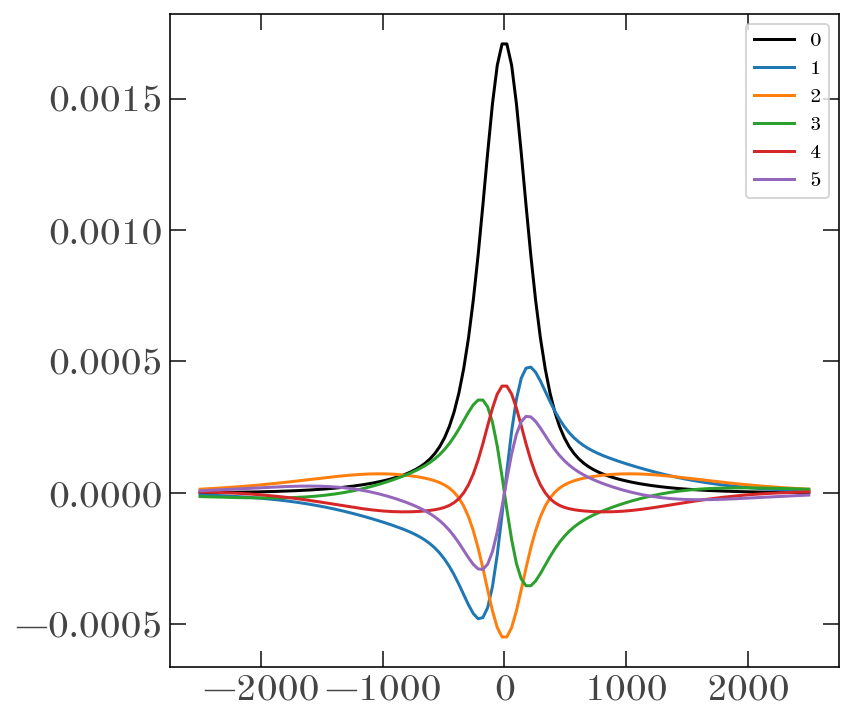

In [69]:
shit = np.linspace(-2500, 2500, 128)
plt.figure(figsize=(6, 6))
for k, bfunc in enumerate(normed_basis_funcs[:6]):
    plt.plot(shit, bfunc(shit), marker='', label=str(k))
plt.legend()

In [6]:
max_dist = 1.5 * u.kpc
min_b = 30 * u.deg

def S(b, d):
    sim_mask = (
        (np.abs(b) > min_b) &
        (d < max_dist)
    )
    return sim_mask

In [76]:
truth = {
    'zsun': 20.8 * u.pc,
    'roll': 1. * u.deg,
    'sgrA': coord.SphericalRepresentation(0.5 * u.deg, -0.4*u.deg, 8.275 * u.kpc)
}


truth_asym = {
    'a0': 1.,
    'a1': 0.4,
    'a2': 0.2,
    'a3': 0.05,
    'a4': 0.05,
    'a5': 0.02
}
for name in AsymDensityModel._coeff_names:
    if name not in truth_asym:
        truth_asym[name] = 0.
truth.update(truth_asym)

In [77]:
# from scipy.special import logsumexp

# def ln_z_density(z, *args, **kwargs):
#     z_arr = np.atleast_1d(z)
#     term1 = ln_two_sech2(z_arr, *args, **kwargs)
#     asym1 = ln_normal(z_arr, -300, 150)
#     asym2 = ln_normal(z_arr, 1200, 400)
#     return logsumexp(
#         [term1, asym1, asym2], 
#         b=np.array([0.88, 0.06, 0.06])[:, None], 
#         axis=0
#     ).reshape(np.shape(z))

# For below:
# rho = np.exp(ln_z_density(zgrid, 
#                           h1=truth['h1'].value, 
#                           h2=truth['h2'].value, 
#                           f=truth['f']))
# np.exp(ln_z_density(0., 
#                     h1=truth['h1'].value, 
#                     h2=truth['h2'].value, 
#                     f=truth['f']))

Text(0.5, 0, '$z$ [pc]')

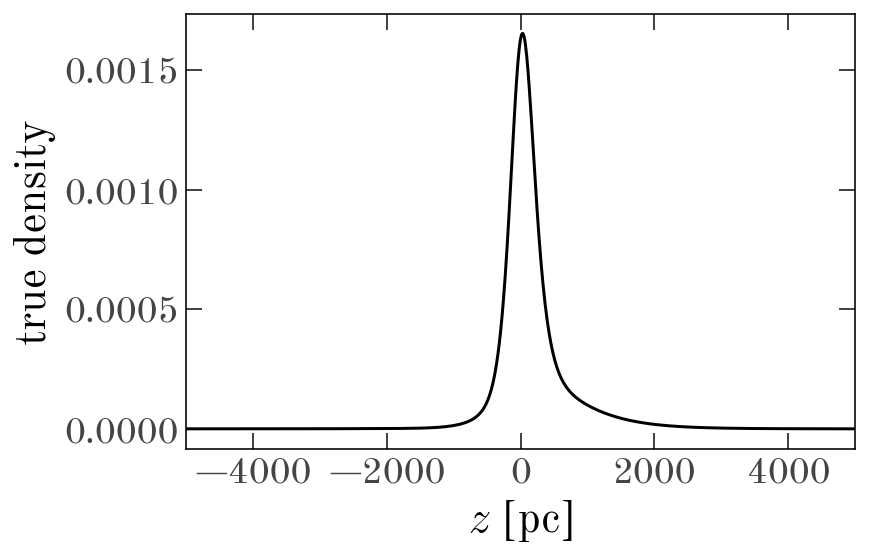

In [78]:
domain = (-5e3, 5e3)  # pc
domain_grid = np.linspace(*domain, 1024)

truth_asym_model = AsymDensityModel(domain=domain, **truth_asym)
rho = np.exp(truth_asym_model._ln_basis_density(domain_grid))

plt.figure(figsize=(6, 4))
plt.plot(domain_grid, rho, marker='')

# Approximating with mixture of gaussians...
# shit_z = np.concatenate((
#     np.random.normal(0, 3e2, size=50_000),
#     np.random.normal(0, 1e3, size=100_000),
#     np.random.normal(0, 1.9e3, size=60_000),
# ))
# plt.hist(shit_z, 
#          bins=np.linspace(-5000, 5000, 128), density=True)

plt.xlim(*domain)
# plt.yscale('log')
plt.ylabel('true density')
plt.xlabel('$z$ [pc]')

In [79]:
N = 1_000_000
truth['ln_n0'] = np.log(N)
rng = np.random.default_rng(seed=42)

z_samples = invt_sample_z(
    truth_asym_model._ln_basis_density,
    size=N,
    rng=rng,
    grid=np.linspace(*domain, 1024)
) * usys['length']

print(np.median(z_samples))

x_args = ((-truth['sgrA'].distance - max_dist).to_value(usys['length']), 
          (-truth['sgrA'].distance + max_dist).to_value(usys['length']))
y_args = ([-1, 1] * max_dist).to_value(usys['length'])
x_samples = rng.uniform(*x_args, size=N) * usys['length']
y_samples = rng.uniform(*y_args, size=N) * usys['length']

# x_samples = rng.normal(
#     -truth['sgrA'].distance.to_value(truth['x_sigma'].unit), 
#     truth['x_sigma'].value, 
#     size=N
# ) * truth['x_sigma'].unit
# y_samples = rng.normal(0, truth['y_sigma'].value, size=N) * truth['y_sigma'].unit

xyz_samples = np.stack((x_samples, y_samples, z_samples), axis=0)
xyz_samples

75.24765191192986 pc


<Quantity [[-7678.56862785, -8390.42389114, -9729.135361  , ...,
            -9113.77738958, -9701.54450403, -8374.01974764],
           [  978.71144744,  1423.7429247 ,   328.17941477, ...,
              -60.42796444, -1258.79351459,  1037.63986654],
           [  314.87134682,    37.91560653,   503.55901926, ...,
              107.9693893 ,  1873.29755651,   195.12979335]] pc>

(-5000.0, 5000.0)

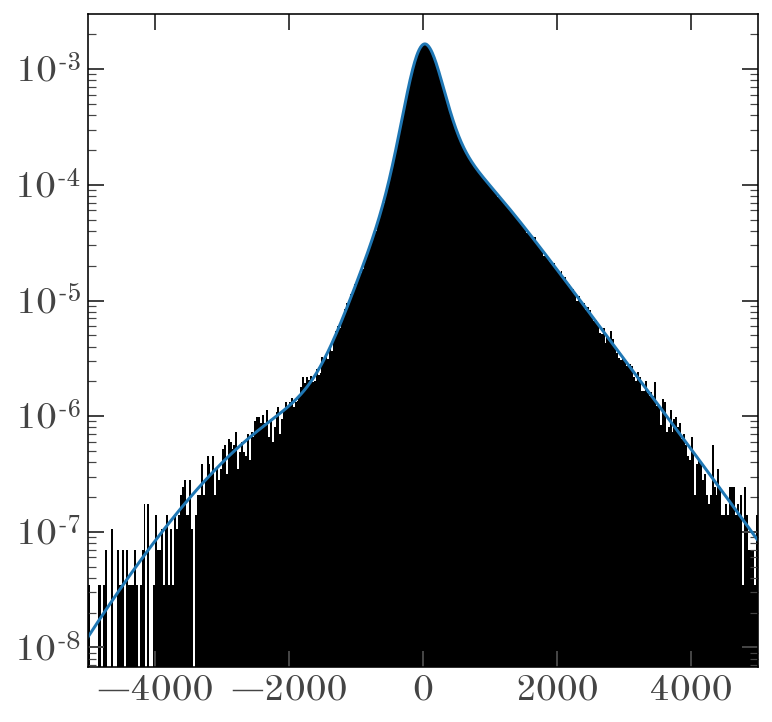

In [80]:
plt.figure(figsize=(6, 6))
plt.hist(z_samples.value, bins=np.linspace(*domain, 351), 
         density=True);

fuck = truth_asym_model._ln_basis_density(domain_grid)
plt.plot(domain_grid, np.exp(fuck), marker='')

plt.yscale('log')
plt.xlim(-5000, 5000)
# plt.ylim(1e-4, 1e-3)

# from scipy.integrate import quad
# quad(
#     lambda z: np.exp(truth_asym_model._ln_basis_density(z)),
#     domain[0], domain[1]
# )

In [81]:
sim_schmagal = coord.CartesianRepresentation(xyz_samples)

sim_gal = coord.CartesianRepresentation(
    schmagal_to_gal(xyz_samples, 
                    truth['sgrA'], truth['zsun'], truth['roll'])
)
sim_gal_sph = sim_gal.represent_as(coord.SphericalRepresentation)

In [82]:
sim_mask = S(sim_gal_sph.lat, sim_gal_sph.distance)
sim_mask.sum(), len(sim_mask)

(95177, 1000000)

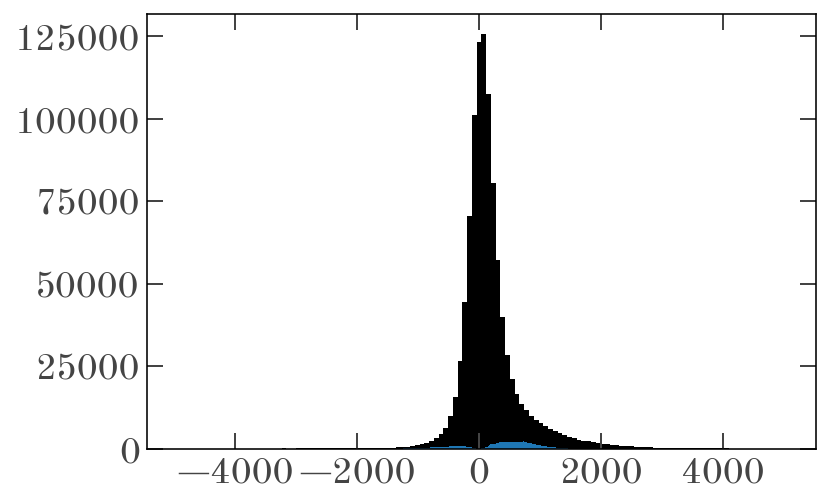

In [83]:
plt.hist(sim_gal.z.value, bins=128);
plt.hist(sim_gal.z.value[sim_mask], bins=128);

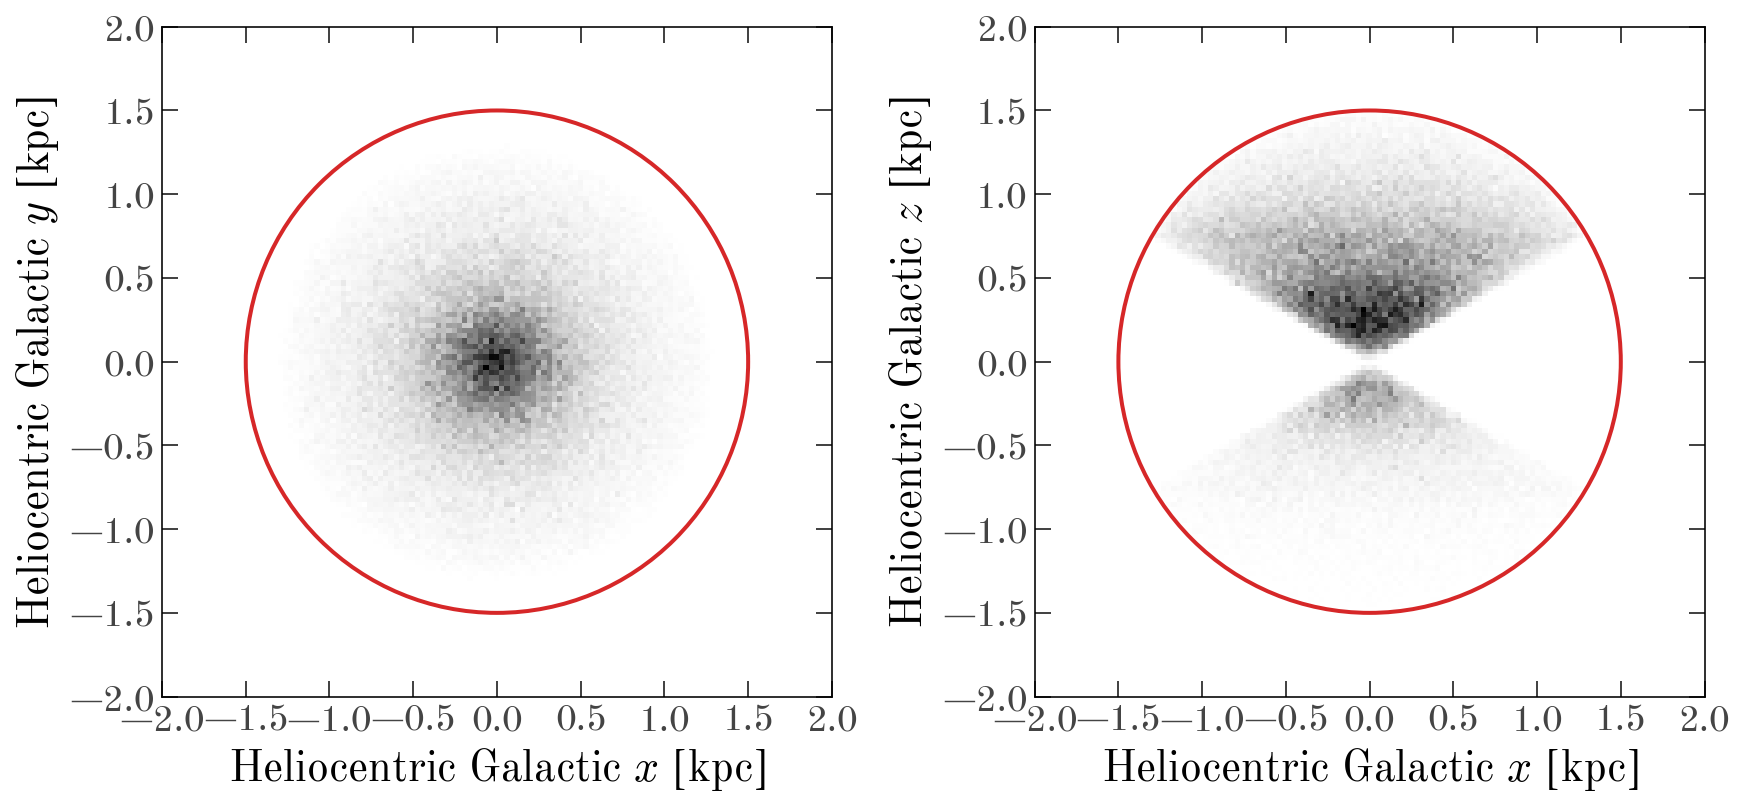

In [84]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(sim_gal.x[sim_mask].to_value(u.kpc), 
                                sim_gal.y[sim_mask].to_value(u.kpc)), 
                               (sim_gal.x[sim_mask].to_value(u.kpc), 
                                sim_gal.z[sim_mask].to_value(u.kpc))], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

In [89]:
data = sim_gal.xyz.decompose(usys)[:, sim_mask]

test_grid = np.zeros((3, 1024))
test_grid[2] = np.linspace(*domain, test_grid.shape[1])

model_kw = dict(
    DensityModel=AsymDensityModel,
    DensityModel_kwargs={'domain': domain},
    sgrA_star=truth['sgrA'], 
    min_abs_b=min_b, 
    max_dist=max_dist, 
    usys=usys,
    frozen={
        'a0': 1,
        'x_a': -max_dist,
        'x_b': max_dist,
        'y_a': -max_dist,
        'y_b': max_dist,
    },
    density_test_grid_xyz=test_grid
)

model = Model(data, **model_kw)
model_all = Model(sim_gal.xyz.decompose(usys), **model_kw)

In [90]:
gal_args = (truth['sgrA'], truth['zsun'], truth['roll'])

density_model = model._get_density_model(truth)
model.ln_integrand(
    0.,
    (31*u.deg).decompose(usys).value,
    (100*u.pc).decompose(usys).value,
    density_model,
    gal_args
)

-13.361860668052453

In [91]:
model.get_ln_Veff(density_model, gal_args)

-2.348886954010704

In [92]:
p0 = model.pack_pars(truth)
model.ln_likelihood(p0)

-1105701.0977853227

In [96]:
sgrA = truth['sgrA']

all_vals = np.linspace(0.9, 1.1, 16)[None] * np.array(p0)[:, None]

all_lls = []
for i in range(len(p0)):
    print(f"\n{i}")
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for j, val in enumerate(vals):
        print(f"{j}/{len(vals)}", end="\r")
        this_p0[i] = val
        lls.append(model.ln_likelihood(this_p0))
    all_lls.append(lls)
all_lls = np.array(all_lls)


0


/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:58: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


15/16
1
15/16
2
15/16
3
15/16
4
15/16
5
15/16
6
15/16
7


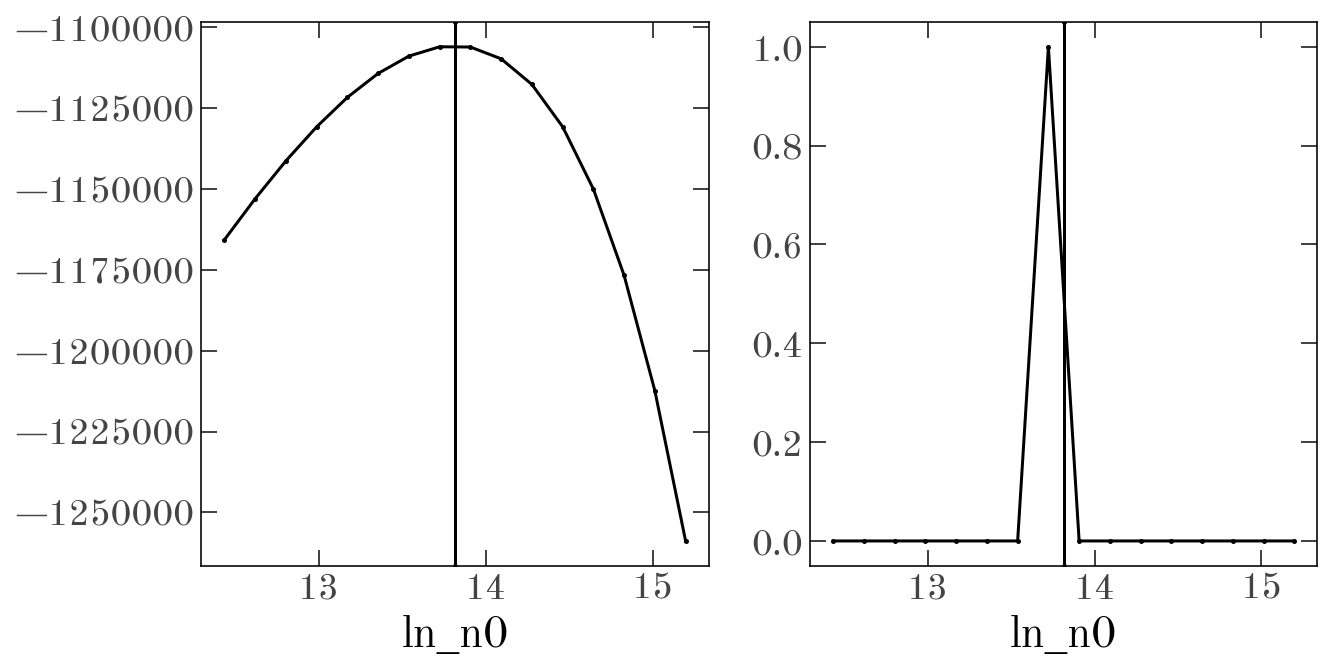

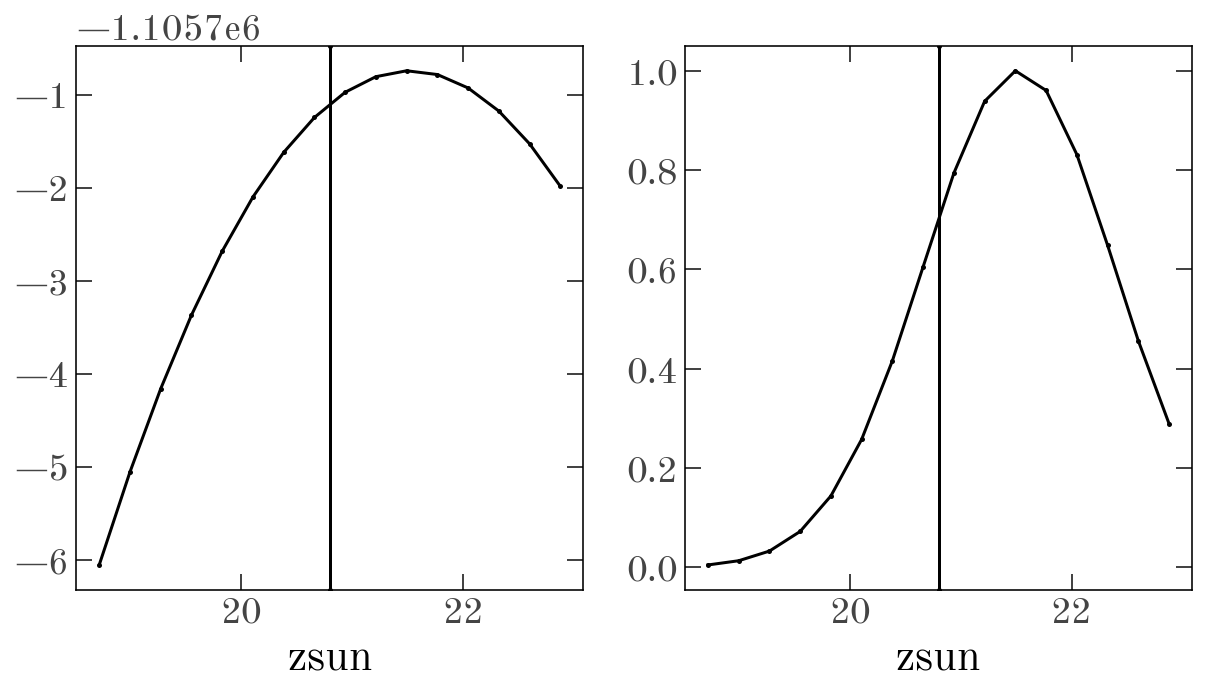

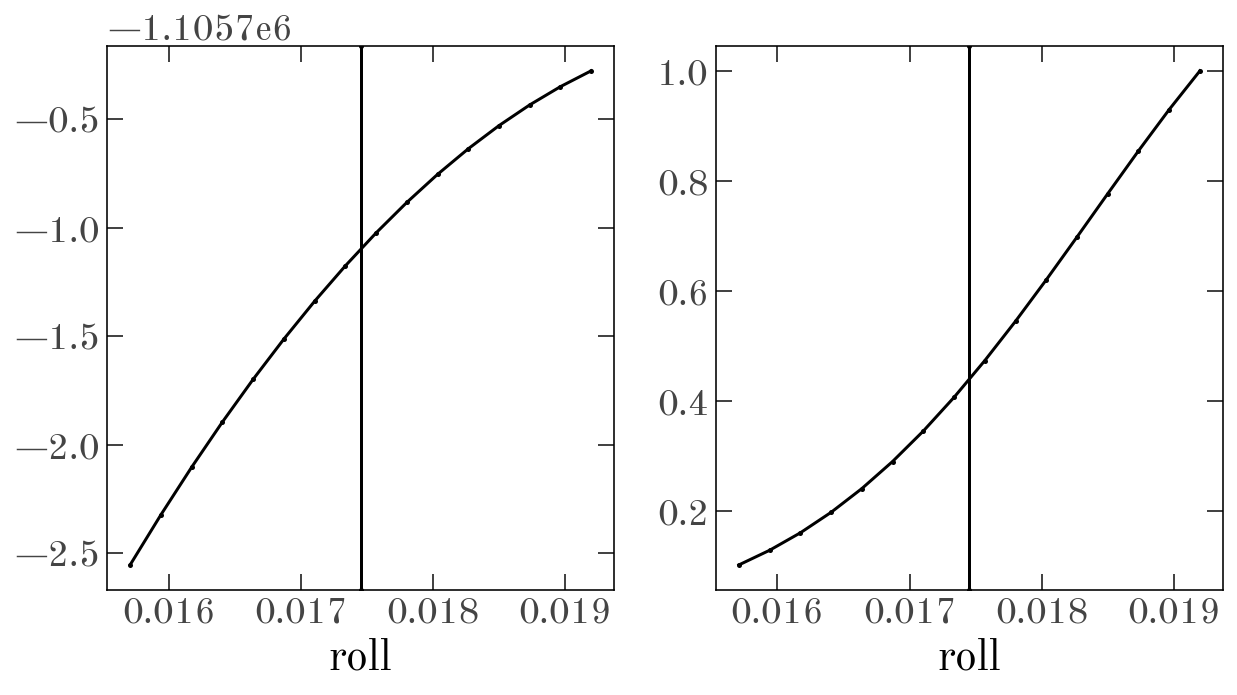

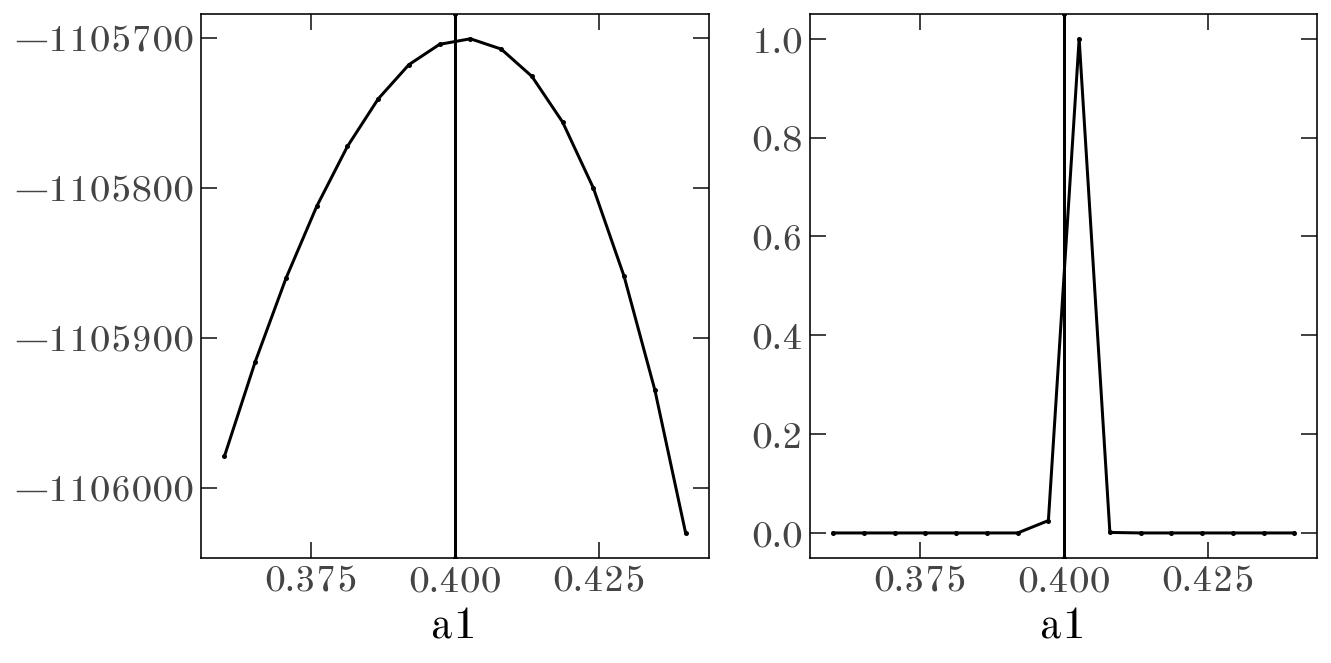

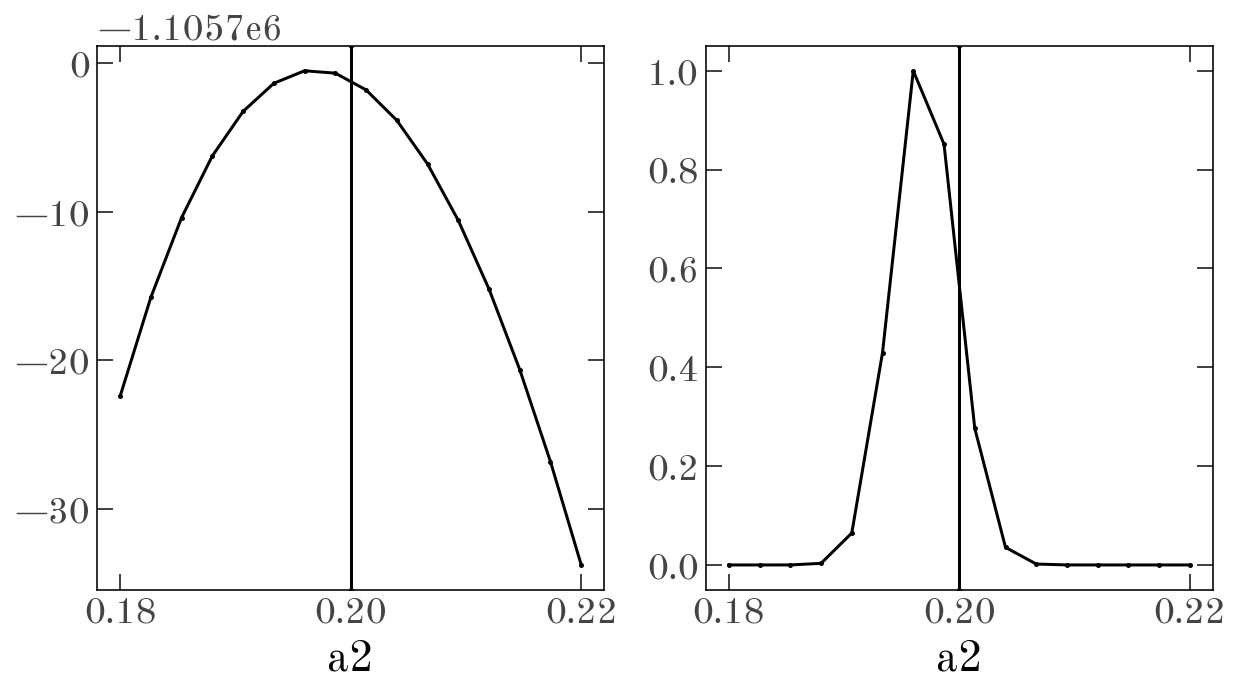

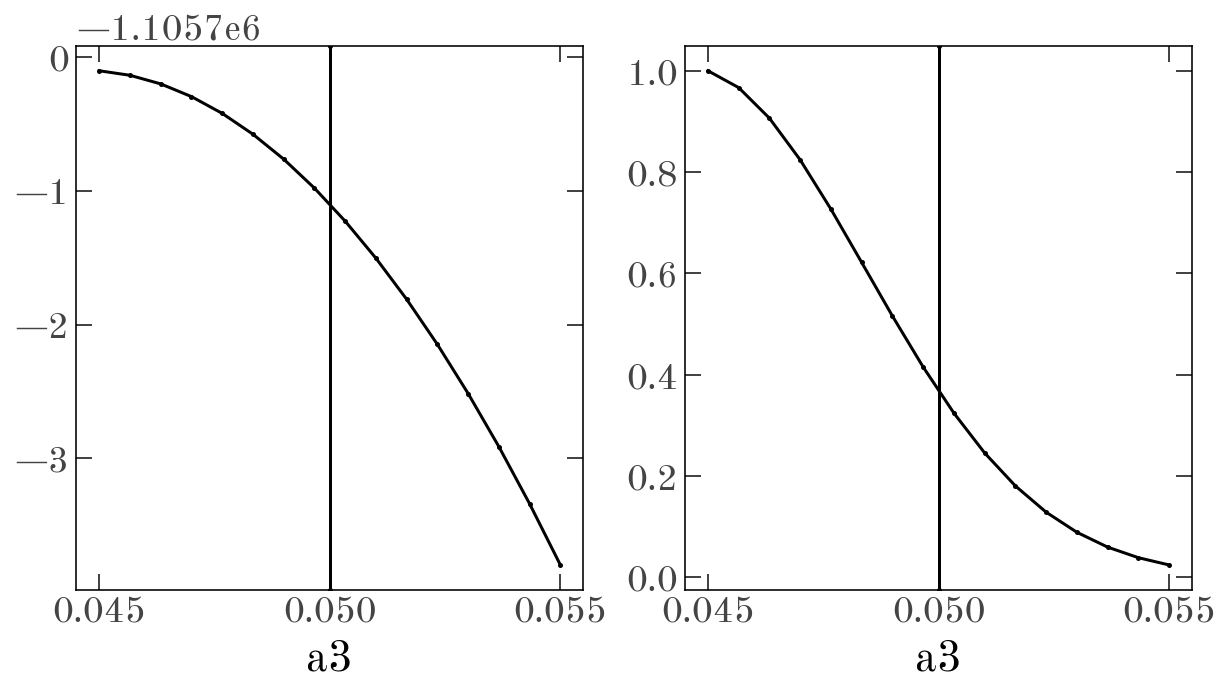

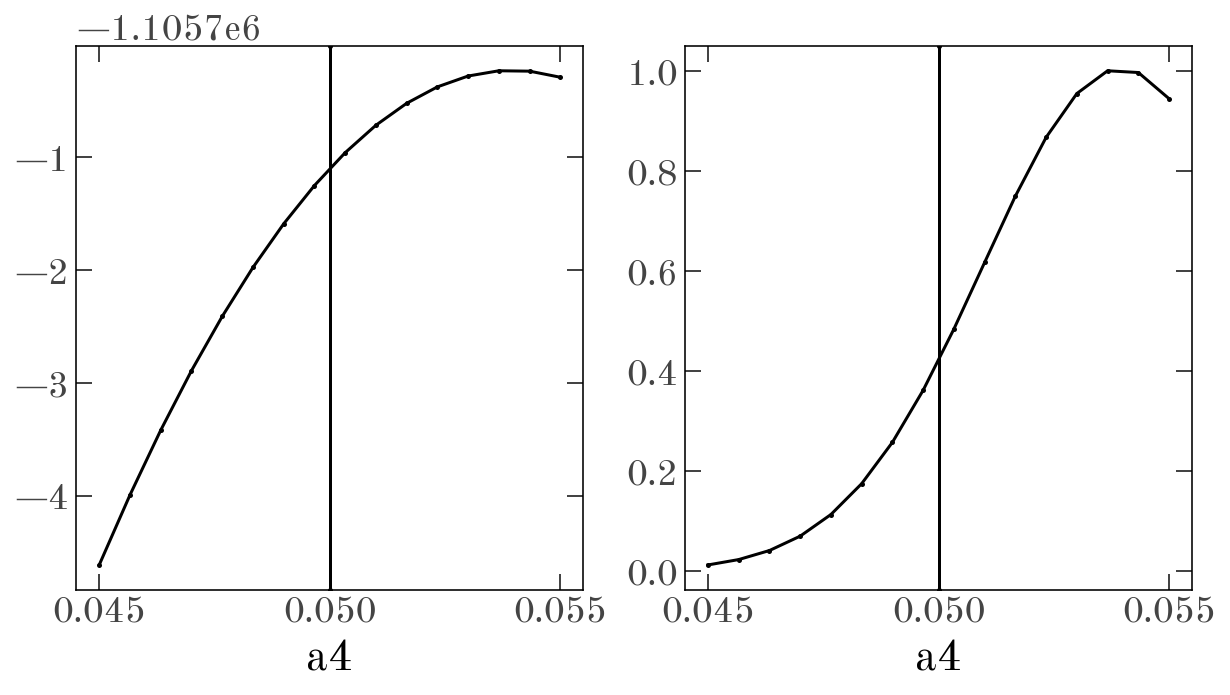

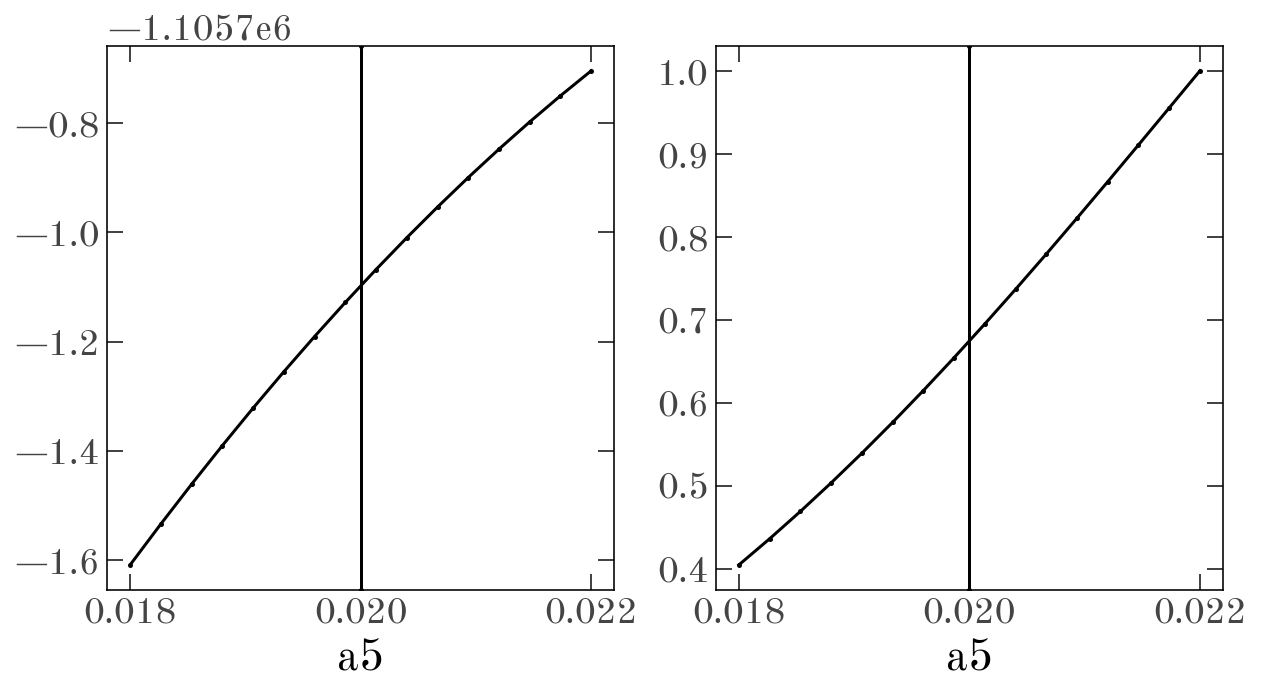

In [97]:
plot_names = [k for k in model.par_names if k not in model.frozen]
for i in range(all_lls.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(plot_names[i])
        ax.axvline(p0[i])

In [99]:
full_res = minimize(
    lambda pp: -model.ln_likelihood(pp) + np.abs(pp[3:]).sum(), 
    x0=p0, 
    method='nelder-mead'
)

/Users/apricewhelan/projects/solar-velocity/solaroid/density.py:95: RuntimeWarning: invalid value encountered in log
  return self._log_normalize + np.log(dens)
/Users/apricewhelan/projects/solar-velocity/solaroid/density.py:85: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalize, err = quad(


In [100]:
np.array(p0)

array([1.38155106e+01, 2.08000000e+01, 1.74532925e-02, 4.00000000e-01,
       2.00000000e-01, 5.00000000e-02, 5.00000000e-02, 2.00000000e-02])

In [101]:
full_res.x

array([13.81314563, 20.51589765,  0.02073326,  0.40059372,  0.19316734,
        0.05485716,  0.04622182,  0.03541494])

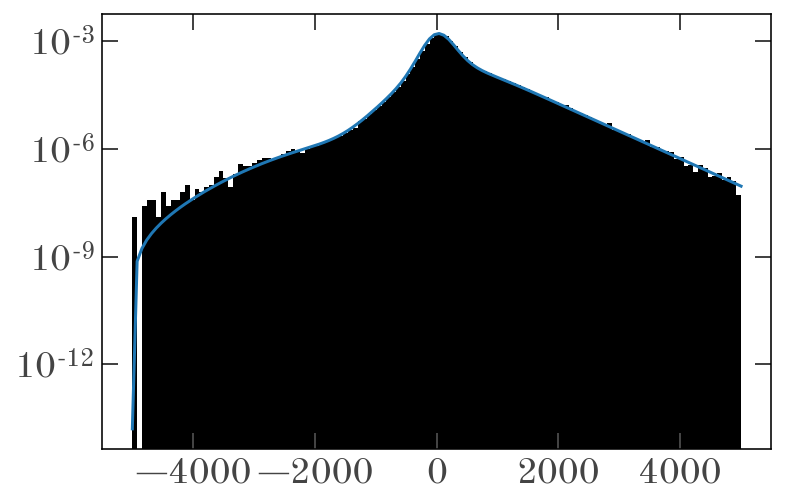

In [102]:
_grid = np.linspace(-5000, 5000, 128)
plt.hist(model_all.data_gal_xyz[2].value, 
         bins=_grid, density=True)

pp = model.unpack_pars(full_res.x)
this_density_model = model._get_density_model(pp)
val = this_density_model._ln_basis_density(_grid)
plt.plot(_grid, np.exp(val), marker='')
plt.yscale('log')

In [104]:
rng = np.random.default_rng(seed=42)

bootstrap_res = []
for i in range(16):
    print(i, end='\r')
    batch = data[:, rng.choice(data.shape[1], size=data.shape[1])]
    batch_model = Model(batch, **model_kw)
    res = minimize(lambda pp: -batch_model.ln_likelihood(pp) + np.abs(pp[3:]).sum(), 
                   x0=p0, method='nelder-mead')
    bootstrap_res.append(res)

/Users/apricewhelan/projects/solar-velocity/solaroid/density.py:95: RuntimeWarning: invalid value encountered in log
  return self._log_normalize + np.log(dens)
/Users/apricewhelan/projects/solar-velocity/solaroid/density.py:85: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalize, err = quad(


In [107]:
np.all([res.success for res in bootstrap_res])

False

In [110]:
bootstrap_optp = np.array([res.x for res in bootstrap_res if res.success])
bootstrap_optp

array([[ 1.38120435e+01,  2.20480643e+01,  2.25067427e-02,
         3.87105904e-01,  1.81117397e-01,  1.61951003e-02,
         3.65382706e-02, -3.65577692e-10],
       [ 1.38152019e+01,  2.13778978e+01,  2.19922441e-02,
         3.95483850e-01,  1.81218457e-01,  5.23738372e-02,
         4.14504422e-02,  3.02929689e-02],
       [ 1.38107555e+01,  1.89868236e+01,  1.93163417e-02,
         3.91670034e-01,  1.85370423e-01,  5.96786807e-07,
         3.12579342e-02, -2.74563506e-03],
       [ 1.38151748e+01,  1.78278829e+01,  2.30208129e-02,
         3.98962828e-01,  1.73639372e-01,  3.50211718e-02,
         2.80242915e-02,  2.56446259e-02],
       [ 1.38199897e+01,  2.20987967e+01,  2.26819699e-02,
         3.90856053e-01,  2.27228105e-01,  3.66386583e-02,
         9.40675404e-02,  1.42605678e-02],
       [ 1.38189519e+01,  2.18102163e+01,  2.05844563e-02,
         4.13724953e-01,  2.53615479e-01,  9.76001616e-02,
         1.13866474e-01,  4.76803012e-02],
       [ 1.38112846e+01,  2.153117

TODO: need to create model with different data...

In [111]:
# plt.figure(figsize=(15, 5))

# plt.subplot(131)
# model_all.ln_likelihood(p0, plot=True);

# plt.subplot(132)
# model_all.ln_likelihood(full_res.x, plot=True);

# plt.subplot(133)
# model_all.ln_likelihood(bootstrap_optp[0], plot=True);

In [112]:
import corner

In [113]:
np.array(p0)

array([1.38155106e+01, 2.08000000e+01, 1.74532925e-02, 4.00000000e-01,
       2.00000000e-01, 5.00000000e-02, 5.00000000e-02, 2.00000000e-02])

In [114]:
np.mean(bootstrap_optp, axis=0)

array([1.38147717e+01, 2.08115514e+01, 2.18372807e-02, 3.96331633e-01,
       1.98017199e-01, 4.04680130e-02, 5.45960024e-02, 2.07900388e-02])

In [121]:
np.std(bootstrap_optp, axis=0)

array([3.39711745e-03, 1.56997799e+00, 1.27389166e-03, 7.99134109e-03,
       2.79409654e-02, 2.85400349e-02, 3.19181525e-02, 1.67248694e-02])

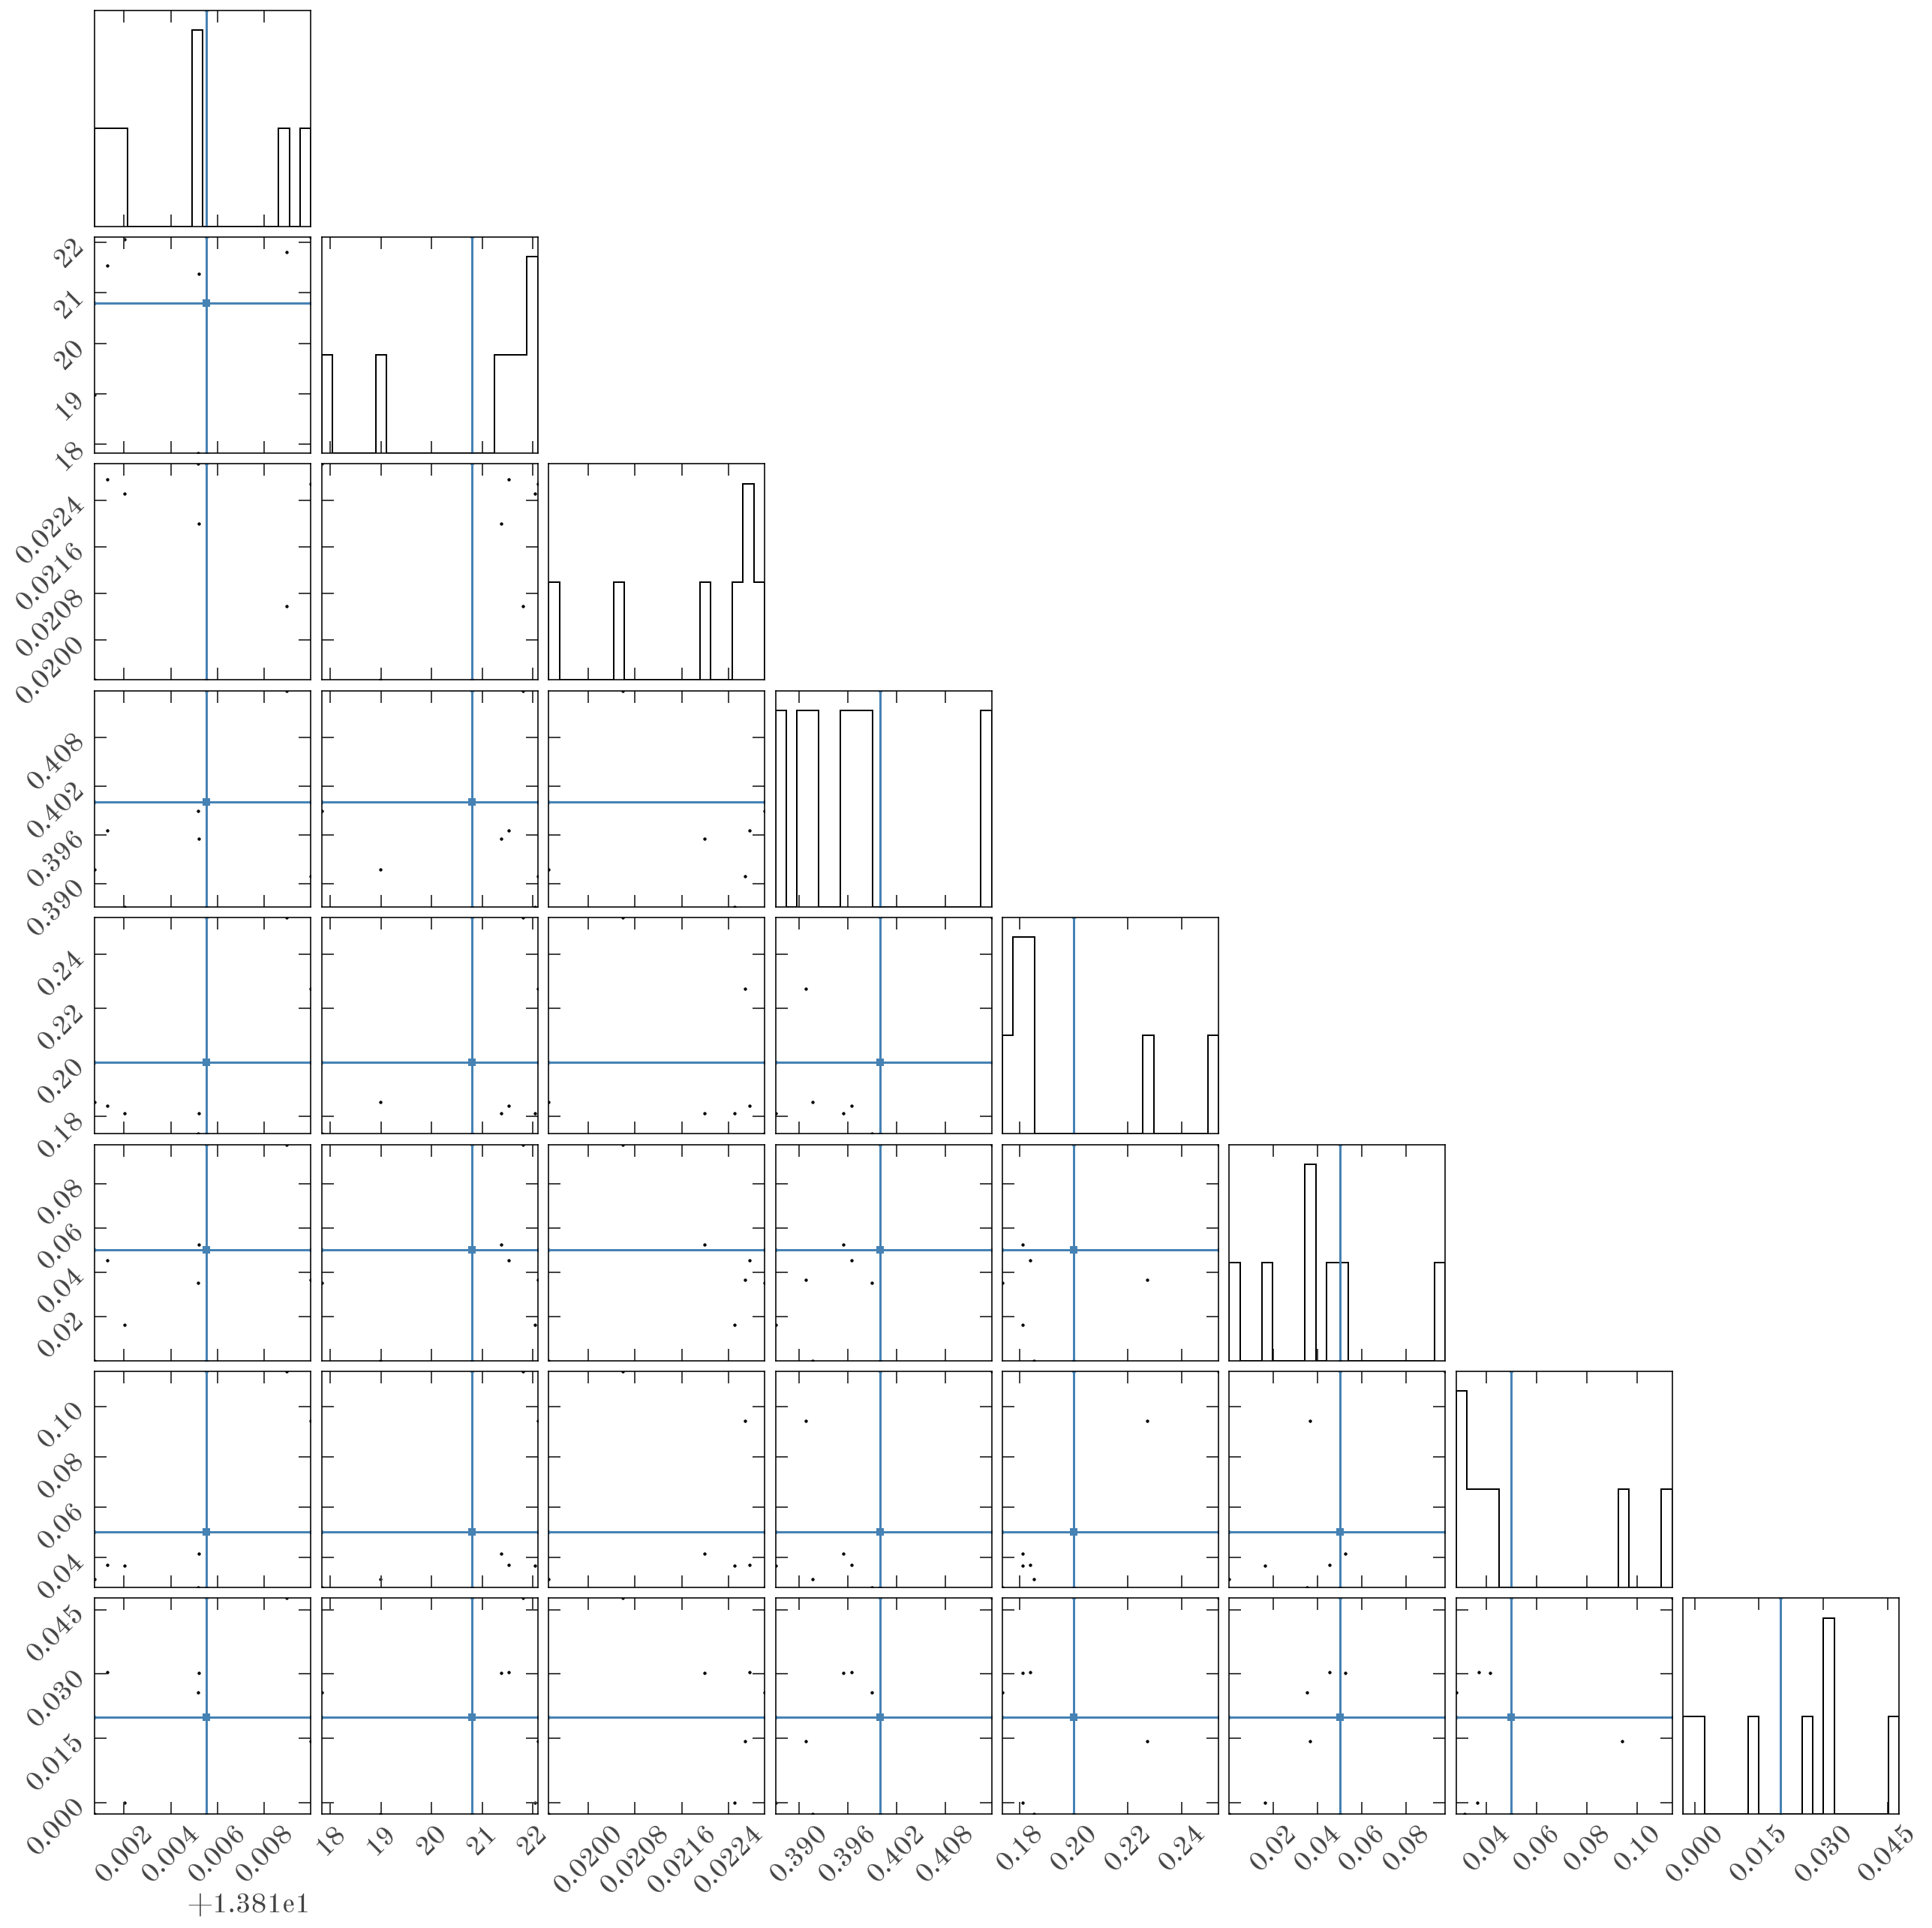

In [120]:
_ = corner.corner(
    np.vstack((bootstrap_optp, bootstrap_optp)), 
    truths=p0, 
    data_kwargs=dict(alpha=1),
    # range=np.array([0.9, 1.1])[None] * np.array(p0)[:, None],
    plot_contours=False, plot_density=False)